# Intro

Some model demo (CNN & RNN), for extensive model experimentation and selection please go to 04 notebooks

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go


# objective and features

In [2]:
def objective_five_percent(df):
    entry = pd.Series(1, index=range(len(df)))
    for day in range(1, 6):
        neutral_idx = entry[entry == 1].index

        # check if reach 5%, then check -5%
        change_pct = (df["High"].shift(-day) - df["Close"]) / df["Close"]
        entry.iloc[neutral_idx] = np.where(change_pct.iloc[neutral_idx] > 0.05, 2, 1)

        neutral_idx = entry[entry == 1].index

        change_pct = (df["Close"] - df["Low"].shift(-day)) / df["Close"]
        entry.iloc[neutral_idx] = np.where(change_pct.iloc[neutral_idx] > 0.05, 0, 1)
    return entry

def kdj(c, h, l):
    h = h.rolling(window=9).max()
    l = l.rolling(window=9).min()

    # raw stochastic value, how close to past min max
    rsv = (100 * ((c - l) / (h - l))).fillna(50)

    def kd_smoothing(factor):
        smoothing = []
        prev = 50
        for i in factor:
            curr = (2 / 3) * prev + (1 / 3) * i
            smoothing.append(curr)
            prev = curr
        return np.array(smoothing)

    # Calculate K, D, and J
    k = kd_smoothing(rsv)
    d = kd_smoothing(k)
    j = 3 * k - 2 * d
    return k, d, j

def gmma(df):
    gmma_ema = [3, 5, 8, 10, 12, 35, 40, 45, 50, 60]
    for i in gmma_ema:
        df[f"{i}ema"] = df["Close"].ewm(span=i).mean()
    return df

def feature_engineering(df):
    close, high, low, volume = df["Close"], df["High"], df["Low"], df["Volume"]

    # start with price related features so we can normalize altogether
    df["psar"] = talib.SAR(high, low, acceleration=0.02, maximum=0.2)
    df = gmma(df)
    df["bb_up"], _, df["bb_low"] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df["bb_wid"] = (df["bb_up"] - df["bb_low"])
    df = df.div(close, axis=0)

    # close, volume and other features
    df["Close"] = close.pct_change()
    df["Volume"] = volume / volume.rolling(window=20).mean()
    df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACDFIX(close, signalperiod=9)
    df["k"], df["d"], df["j"] = kdj(close, high, low)

    df[df.columns] = StandardScaler().fit_transform(df)

    return df

def get_plotly(df, ticker):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                                        open=df["Open"],
                                        high=df["High"],
                                        low=df["Low"],
                                        close=df["Close"])])

    fig.update_layout(
            title=f"{ticker} price",
            xaxis_title="Date",
            yaxis_title="Price",
            autosize=True,
            # showlegend=True,
            xaxis_rangeslider_visible=False,
            margin=dict(l=0, r=10, t=50, b=50)
        )
    return fig

In [3]:
ticker = "TSLA"
df = yf.download(ticker, period="5y", interval="1d", progress=False)


In [4]:
entry = objective_five_percent(df)
print(entry.value_counts())
df["entry"] = entry.values

fig = get_plotly(df, ticker)

result_pairs = [[0, 1.05, "bear", "red"],
                [1, 1.00, "neutral", "black"],
                [2, 0.95, "bull", "green"]]

for [flag, factor, name, color] in result_pairs:
    idx = df[df["entry"] == flag].index
    fig.add_trace(
        go.Scatter(
            x=idx,
            y=df["Close"][idx] * factor,
            mode="markers+text",
            marker=dict(color=color, size=8),
            name=name
            )
            )
fig.show()

2    569
0    514
1    176
Name: count, dtype: int64


C:\Users\edton\AppData\Local\Temp\ipykernel_140640\2102823166.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



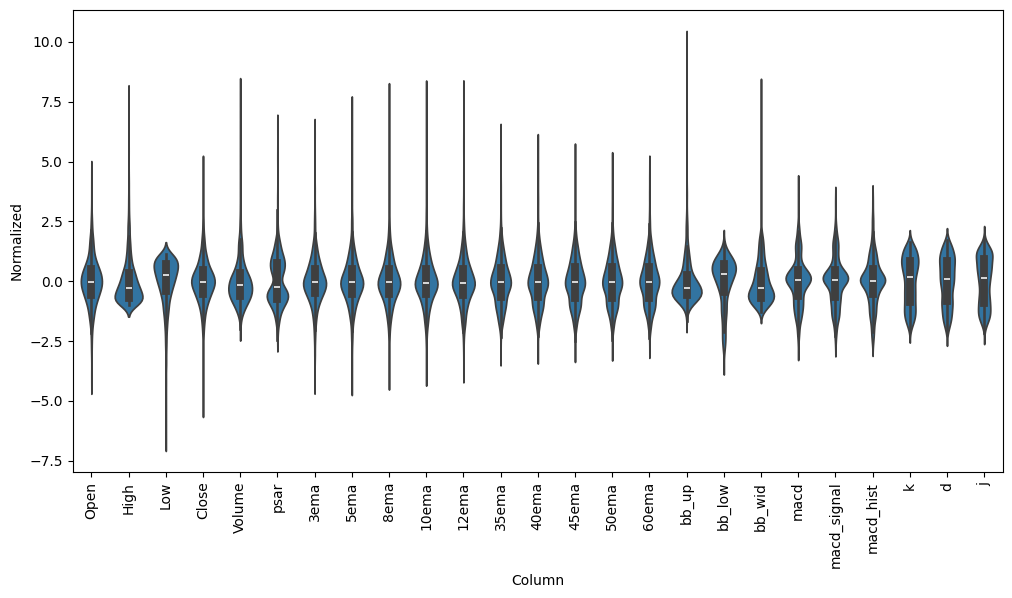

In [5]:
df = feature_engineering(df)
df = df.drop(columns=["Adj Close", "entry"])
df_violin = df.melt(var_name="Column", value_name="Normalized")

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_violin)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [6]:
df["entry"] = entry.values
df = df.dropna()


# split data

In [7]:
n = len(df)
train_df = df[:int(n*0.8)]
val_df = df[int(n*0.8):]

In [8]:
np.array(train_df).shape

(980, 26)

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [10]:
def split_window(data, labels, sequence_length):
    data = np.array(data)
    labels = np.array(labels)
    sequences = []
    seq_labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        seq_labels.append(labels[i + sequence_length - 1])
    return np.array(sequences), np.array(seq_labels)




In [11]:
sequence_length = 15
# x, y = split_window(train_df.drop(columns=["entry"]), train_df["entry"], sequence_length)
X_train, y_train = split_window(train_df.drop(columns=["entry"]), train_df["entry"], sequence_length)
X_val, y_val = split_window(val_df.drop(columns=["entry"]), val_df["entry"], sequence_length)

In [12]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(965, 15, 25) (965,)
(231, 15, 25) (231,)


In [13]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=X_train.shape[1:]),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")  # 3 classes for classification
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

c:\Users\edton\miniconda3\envs\trading\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [14]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,
    validation_data=(X_val, y_val),
    batch_size=32
)

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4222 - loss: 1.0226 - val_accuracy: 0.3896 - val_loss: 1.0796
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4806 - loss: 0.9358 - val_accuracy: 0.3680 - val_loss: 1.0843
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5505 - loss: 0.8804 - val_accuracy: 0.3463 - val_loss: 1.0948
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5702 - loss: 0.8700 - val_accuracy: 0.3550 - val_loss: 1.0838
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5765 - loss: 0.8890 - val_accuracy: 0.3160 - val_loss: 1.1550
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5500 - loss: 0.8594 - val_accuracy: 0.3463 - val_loss: 1.1215
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5639 - loss: 0.8609 - val_accuracy: 0.3463 - val_loss: 1.1408
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5916 - loss: 0.8440 - val_accuracy: 0.4113 - val_loss

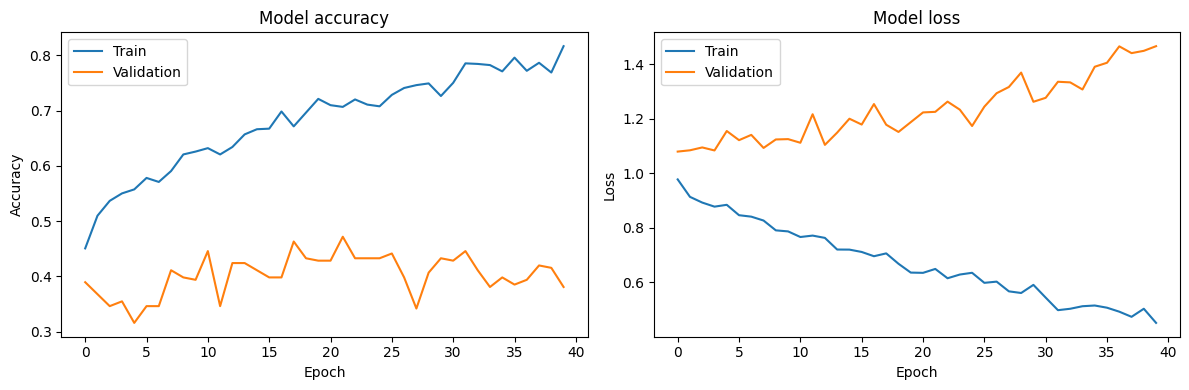

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.layers import LSTM


In [17]:
# Define the RNN model
model = Sequential([
    LSTM(50, activation="relu", input_shape=X_train.shape[1:], return_sequences=True),
    LSTM(50, activation="relu"),
    Dense(128, activation="relu"),
    Dense(3, activation="softmax")  # 3 classes for classification
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

c:\Users\edton\miniconda3\envs\trading\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [19]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,
    validation_data=(X_val, y_val),
    batch_size=32
)


Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8934 - loss: 0.2460 - val_accuracy: 0.3247 - val_loss: 2.9050
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9123 - loss: 0.2276 - val_accuracy: 0.3506 - val_loss: 3.3080
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9103 - loss: 0.2359 - val_accuracy: 0.3377 - val_loss: 2.9753
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8994 - loss: 0.2869 - val_accuracy: 0.3074 - val_loss: 2.8007
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8994 - loss: 0.2598 - val_accuracy: 0.3160 - val_loss: 3.4685
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8911 - loss: 0.2477 - val_accuracy: 0.3636 - val_loss: 3.1227
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9031 - loss: 0.2272 - val_accuracy: 0.2641 - val_loss: 3.6351
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9518 - loss: 0.1521 - val_accuracy: 0.3247 - v

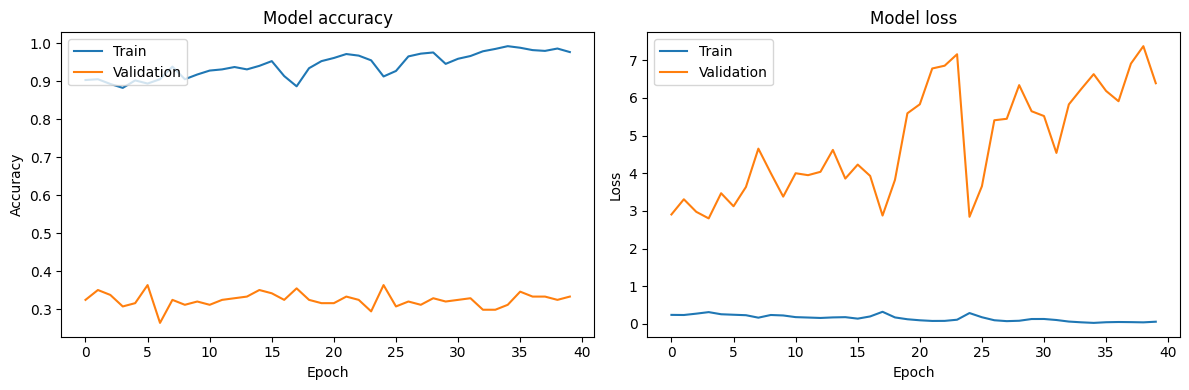

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")

plt.tight_layout()
plt.show()
